<a href="https://colab.research.google.com/github/niamhgraham/Niamh/blob/master/ProspectInterview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prospect Football Interview Task

One of the main requirements of the Data Scientist role at Prospect is to use various datasets to create new and novel metrics to explain team and player performance. With that in mind and with the datasets provided, we’d like you to create a presentation explaining the different playing styles of the teams participating in the J League in 2024, using any modelling or statistical techniques of your choice.



We’re particularly interested to learn if you can tell us how they vary in their approaches in build-up and how they also look to defend. We’d also like you to do a deep dive on a single team of interest, analysing their strengths and weaknesses.



You’ll be required to present your presentation back to a panel representing the roles of a Sporting Director, Head of Recruitment and Head Coach. Please consider how your presentation should cater to these different stakeholders and what potential questions could come up when discussing how these teams play.

**Consideraions**

*   What metrics contribute to build up play
*   What metrics contribute to defensive play
*   Carry out a PCA on the metrics to try and find a defensive and build up
*   Look at how effective the strategies are by looking at how many chances/shots/xg team has and how many goals they have conceded.
*   Look at how formations reflect the aggregated stats
*   Bar charts showing teams in carrying out different actions the most/least times


Stats to consider:

*   xG as a metric of how well team working to get ball forward, xG conceded a measure of well they are defending.
*   Look at actual goals conceded v xg conceded and xg vs goals to see which teams are over/underperforming
*   Relative frequency of events rather than raw events (i.e. a certain percentage of a teams in-posession events were carries)
*   Heatmaps of team events in deep dive
*   Areas on pitch where defensive actions occur e.g. interceptions/tackles
*   lengths of passes, short or longer

Resources:

https://statsbomb.com/articles/soccer/modelling-team-playing-style/
https://optaplayerstats.statsperform.com/en_GB/soccer/j1-league-2024/2uwdznd3ybsmgybndt2aaq9sk/standings - standings in league
https://www.sportsmole.co.uk/football/j1-league/2024/ - this shows tables on best defence (based on clean sheets and least goals against - can get that with the match_data), best attack - based on goals
https://statsbomb.com/wp-content/uploads/2024/09/Michael-Gleeson-Statsbomb-Research-Conference-2024-Draft-2.docx-1.pdf


Info:

Build up play - phase of play when a team are in posession. How they work past the oppositions defence to work the ball up the field towards the opposing goal, how they work through the thirds of the pitch.

Goal kicks are they long boots or just passing sideways to defenders. What areas of pitch would they build out
Through middle , round or over the top (booting).
Sucessful progressive passes, what direction and length of passes. Unsuccessful passes. How many long or short passes from certain areas of pitch.

Defending - average player positions - out of possession, high/low block where are successful tackles/interceptions transition in - where in possible.

Deep press: A conservative tactic where the defending team tries to intercept the ball in the last third of the pitch
Middle press: A tactic where the defending team is closer to the opponent's goal
High pressing: A tactic where the team applies pressure in their own half

In [2]:
import numpy as np
import json
import glob
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import os
import requests
import json
import math
from google.colab import files, drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = "/content/drive/My Drive/JOBS/Jobs/ProspectInterview/sb_events.json"  # Adjust this path
with open(file_path, "r", encoding="utf-8") as file:
    events_df = json.load(file)

file_path = "/content/drive/My Drive/JOBS/Jobs/ProspectInterview/sb_matches.json"  # Adjust this path
with open(file_path, "r", encoding="utf-8") as file:
    matches_df = json.load(file)

In [5]:
#load in data
matches_df=pd.json_normalize(matches_df)
events_df=pd.json_normalize(events_df)

In [6]:
events_df.columns = events_df.columns.str.replace(".name", "", regex=True)
matches_df.columns = matches_df.columns.str.replace(".name", "", regex=True)

In [7]:
pd.set_option('display.max_columns', None)

In [37]:
events_df.head(10)

,id,index,period,timestamp,minute,second,possession,duration,related_events,location,type.id,type,possession_team.id,possession_team,play_pattern.id,play_pattern,team.id,team,tactics.formation,tactics.lineup,pass.end_location,carry.end_location,shot.end_location,shot.freeze_frame,goalkeeper.end_location,match_id,obv_for_after,obv_for_before,obv_for_net,obv_against_after,obv_against_before,obv_against_net,obv_total_net,player.id,player,position.id,position,pass.length,pass.angle,pass.pass_success_probability,pass.recipient.id,pass.recipient,pass.height.id,pass.height,pass.body_part.id,pass.body_part,pass.type.id,pass.type,pass.pass_cluster_id,pass.pass_cluster_label,pass.pass_cluster_probability,under_pressure,pass.aerial_won,pass.outcome.id,pass.outcome,duel.type.id,duel.type,clearance.right_foot,clearance.body_part.id,clearance.body_part,clearance.head,ball_receipt.outcome.id,ball_receipt.outcome,pass.switch,out,counterpress,shot.statsbomb_xg,shot.shot_execution_xg,shot.shot_execution_xg_uplift,shot.gk_positioning_xg_suppression,shot.technique.id,shot.technique,shot.body_part.id,shot.body_part,shot.type.id,shot.type,shot.outcome.id,shot.outcome,goalkeeper.position.id,goalkeeper.position,goalkeeper.type.id,goalkeeper.type,clearance.aerial_won,goalkeeper.body_part.id,goalkeeper.body_part,goalkeeper.outcome.id,goalkeeper.outcome,interception.outcome.id,interception.outcome,duel.outcome.id,duel.outcome,shot.first_time,off_camera,pass.assisted_shot_id,pass.goal_assist,pass.through_ball,pass.technique.id,pass.technique,shot.one_on_one,shot.gk_save_difficulty_xg,shot.gk_shot_stopping_xg_suppression,shot.key_pass_id,goalkeeper.technique.id,goalkeeper.technique,dribble.outcome.id,dribble.outcome,ball_recovery.recovery_failure,foul_committed.card.id,foul_committed.card,foul_won.defensive,pass.shot_assist,pass.inswinging,pass.cross,injury_stoppage.in_chain,substitution.outcome.id,substitution.outcome,substitution.replacement.id,substitution.replacement,clearance.left_foot,pass.no_touch,shot.saved_off_target,goalkeeper.shot_saved_off_target,50_50.outcome.id,50_50.outcome,pass.cut_back,block.offensive,foul_committed.advantage,foul_won.advantage,pass.miscommunication,dribble.nutmeg,pass.deflected,block.deflection,pass.outswinging,clearance.other,bad_behaviour.card.id,bad_behaviour.card,foul_committed.type.id,foul_committed.type,dribble.overrun,block.save_block,miscontrol.aerial_won,shot.aerial_won,foul_committed.offensive,pass.straight,ball_recovery.offensive,shot.deflected,shot.open_goal,goalkeeper.punched_out,foul_committed.penalty,foul_won.penalty,shot.shot_shot_assist,dribble.no_touch,shot.saved_to_post,goalkeeper.shot_saved_to_post,shot.shot_goal_assist,shot.follows_dribble,goalkeeper.lost_out,goalkeeper.lost_in_play,player_off.permanent,shot.redirect,goalkeeper.success_out,goalkeeper.success_in_play
0,dc1f3c18-004f-45d9-8f86-71d670f9cd97,1,1,00:00:00.000,0,0,1,0.0000,None,None,35,Starting XI,1881,Kashima Antlers,1,Regular Play,1881,Kashima Antlers,442.0,"[{'jersey_number': 1, 'player.id': 126936, 'pl...",None,None,None,None,None,3925601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8e81e4fd-fc8c-4efb-b9c4-6d2a55008d43,2,1,00:00:00.000,0,0,1,0.0000,None,None,35,Starting XI,1881,Kashima Antlers,1,Regular Play,4609,FC Machida Zelvia,352.0,"[{'jersey_number': 1, 'player.id': 37269, 'pla...",None,None,None,None,None,3925601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [15]:
main_data = pd.DataFrame({
    'match_id':[],
    'player': [],
    'team':[],
    'team_against':[],
    'position':[],
    'event_type':[],
    'duel_type':[],
    'start_loc': [],
    'end_loc':[],
    'pressure':[],
    'length':[],
    'progressive':[],
    'success':[],
    'match_status':[]
    })

In [16]:
match_data=events_df

In [45]:
new_rows = []  # List to hold rows

# Filter to relevant event types
event_types = ['Pass', 'Carry', 'Duel', 'Block', 'Clearance','Shot']
mask = np.logical_or.reduce([match_data['type'] == event for event in event_types])
match_data = match_data[mask]

# Initialize match scores for each match
match_scores = {}  # {match_id: {home_team: 0, away_team: 0}}

# Loop through all matches
for _, match in matches_df.iterrows():
    match_id = match['match_id']
    home_team = match['home_team.home_team']
    away_team = match['away_team.away_team']

    # Initialize match score dictionary for this match
    match_scores[match_id] = {home_team: 0, away_team: 0}

    # Get all events for this match
    match_events = match_data[match_data['match_id'] == match_id]

    # Loop through events in this match
    for _, event in match_events.iterrows():
        if pd.notna(event['player']):
            player_name = event['player']
            position = event['position']
            team = event['team']

            # Assign the opposing team
            team_against = away_team if team == home_team else home_team

            event_type = event['type']
            start_loc = event['location']
            pressure = event.get('under_pressure', None)

            # Check for goals and update match status
            if event_type == 'Shot':
                if event['shot.outcome'] == 'Goal':
                      match_scores[match_id][team] += 1
                      #print(match_scores)
            # Determine match status (winning, losing, drawing)
            team_score = match_scores[match_id][team]
            opponent_score = match_scores[match_id][team_against]

            if team_score > opponent_score:
                match_status = 'Winning'
            elif team_score < opponent_score:
                match_status = 'Losing'
            else:
                match_status = 'Drawing'
            #print(match_status)

            # Process event attributes
            if event_type == 'Pass':
                end_loc = event['pass.end_location']
                length = event['pass.length']
                progressive = -math.pi/4 <= event['pass.angle'] <= math.pi/4
                outcome = event.get('pass.outcome', None)
                success = pd.isna(outcome)
                duel_type = 'na'

            elif event_type == 'Carry':
                end_loc = event['carry.end_location']
                length = math.sqrt((end_loc[0] - start_loc[0])**2 + (end_loc[1] - start_loc[1])**2)
                progressive = start_loc[0] < end_loc[0]
                success = 'na'
                duel_type = 'na'

            elif event_type == 'Duel':
                end_loc = start_loc
                length = 'na'
                duel_type = event.get('duel.type', 'na')
                outcome = event.get('duel.outcome', None)
                progressive = 'na'
                success = pd.isna(outcome)

            elif event_type in ['Block', 'Clearance']:
                end_loc = start_loc
                length = 'na'
                progressive = 'na'
                success = 'na'
                duel_type = 'na'

            # Append new row
            new_row = {
                'match_id': match_id,
                'player': player_name,
                'team': team,
                'team_against': team_against,
                'position': position,
                'event_type': event_type,
                'duel_type': duel_type,
                'start_loc': start_loc,
                'end_loc': end_loc,
                'pressure': pressure,
                'length': length,
                'progressive': progressive,
                'success': success,
                'match_status': match_status  # Added match status
            }
            new_rows.append(new_row)

# Convert to DataFrame and merge with existing data
if new_rows:
    temp_df = pd.DataFrame(new_rows)
    main_data = pd.concat([main_data, temp_df], ignore_index=True)


In [47]:
main_data['duel_type'].unique()

array(['na', 'Aerial Lost', 'Tackle'], dtype=object)

In [49]:
main_data=main_data[main_data['duel_type']!='Aerial Lost']
#Duel is now just tackle
main_data['event_type']=main_data['event_type'].replace('Duel','Tackle')
#dropping duel type
main_data.drop('duel_type',axis=1)

In [64]:
# Define a dictionary to map detailed positions to broader categories
position_mapping = {
    'Goalkeeper': 'Goalkeeper',  # Excluded from current PAR model

    # Full Backs
    'Right Back': 'Full Back',
    'Left Back': 'Full Back',

    # Centre Backs
    'Right Center Back': 'Centre Back',
    'Left Center Back': 'Centre Back',
    'Center Back': 'Centre Back',

    # Midfielders (Defensive Midfielders and Central Midfielders)
    'Right Wing Back': 'Midfielder',
    'Left Wing Back': 'Midfielder',
    'Left Defensive Midfield': 'Midfielder',
    'Right Defensive Midfield': 'Midfielder',
    'Center Defensive Midfield': 'Midfielder',
    'Left Midfield': 'Midfielder',
    'Right Midfield': 'Midfielder',
    'Left Center Midfield': 'Midfielder',
    'Right Center Midfield': 'Midfielder',
    'Center Midfield': 'Midfielder',

    # Wingers
    'Left Wing': 'Winger',
    'Right Wing': 'Winger',

    # Forwards
    'Center Attacking Midfield': 'Forward',
    'Left Attacking Midfield': 'Forward',
    'Right Attacking Midfield': 'Forward',
    'Left Center Forward': 'Forward',
    'Right Center Forward': 'Forward',
    'Center Forward':'Forward'
}


main_data['broad_position'] =main_data['position'].map(position_mapping)

In [65]:
main_data.to_csv("/content/drive/My Drive/JOBS/Jobs/ProspectInterview/main_data.csv", index=False)


In [68]:
###aggregated event data per team

def aggregate_team_broad_position(data):
    # Convert location strings to tuples if necessary
    if isinstance(data['start_loc'].iloc[0], str):
        data['start_loc'] = data['start_loc'].apply(eval)  # Convert string to tuple
        data['end_loc'] = data['end_loc'].apply(eval)

    # Extract x, y coordinates
    data['start_x'] = data['start_loc'].apply(lambda loc: loc[0])
    data['start_y'] = data['start_loc'].apply(lambda loc: loc[1])
    data['end_x'] = data['end_loc'].apply(lambda loc: loc[0])

    # Compute pass length if not already present
    data['length'] = np.sqrt((data['end_x'] - data['start_x'])**2 + (data['end_loc'].apply(lambda loc: loc[1]) - data['start_y'])**2)

    # Ensure Boolean columns
    data['progressive'] = data['progressive'].astype(bool)
    data['success'] = data['success'].astype(bool)

    # Define final third
    final_third_x = 120 * 0.66  # Pitch is 120 length

    # Aggregate data
    agg_data = data.groupby(['team', 'broad_position']).agg(
        no_passes=('event_type', lambda x: (x == 'Pass').sum()),
        no_tackles=('event_type', lambda x: (x == 'Tackle').sum()),
        no_shots=('event_type', lambda x: (x == 'Shot').sum()),
        no_carries=('event_type', lambda x: (x == 'Carry').sum()),
        no_long_passes=('length', lambda x: (x >= 40).sum()),
        no_short_passes=('length', lambda x: (x < 40).sum()),
        no_progressive_passes=('progressive', 'sum'),
        no_successful_passes=('success', 'sum'),
        no_successful_progressive_passes=('success', lambda x: (x & data['progressive']).sum()),
        no_successful_carries=('event_type', lambda x: ((x == 'Carry') & data['success']).sum()),
        no_successful_short_passes=('event_type', lambda x: ((x == 'Pass') & (data['length'] < 40) & data['success']).sum()),
        no_successful_long_passes=('event_type', lambda x: ((x == 'Pass') & (data['length'] >= 40) & data['success']).sum()),
        no_clearances=('event_type', lambda x: (x == 'Clearance').sum()),
        no_blocks=('event_type', lambda x: (x == 'Block').sum()),
        no_progressive_passes_left=('event_type', lambda x: ((x == 'Pass') & data['progressive'] & (data['start_y'] < 26.67)).sum()),
        no_progressive_passes_middle=('event_type', lambda x: ((x == 'Pass') & data['progressive'] & (data['start_y'].between(26.67, 53.33))).sum()),
        no_progressive_passes_right=('event_type', lambda x: ((x == 'Pass') & data['progressive'] & (data['start_y'] >= 53.33)).sum()),
        no_long_passes_final_third=('event_type', lambda x: ((x == 'Pass') & (data['length'] >= 40) & (data['end_x'] >= final_third_x)).sum()),
        no_successful_passes_final_third=('event_type', lambda x: ((x == 'Pass') & (data['end_x'] >= final_third_x) & data['success']).sum()),
        avg_length_progressive_passes=('length', lambda x: x[data['progressive']].mean()),
        avg_x_location_blocks=('start_x', lambda x: x[data['event_type'] == 'Block'].mean()),
        avg_x_location_tackles=('start_x', lambda x: x[data['event_type'] == 'Tackle'].mean()),
    ).reset_index()

    return agg_data

# Example usage
aggregated_data = aggregate_team_broad_position(main_data)

              team broad_position  no_passes  no_tackles  no_shots  \
0  Albirex Niigata    Centre Back      11622         160        42   
1  Albirex Niigata        Forward       4842         134       340   
2  Albirex Niigata      Full Back      10054         296        84   
3  Albirex Niigata     Goalkeeper       3390           0         0   
4  Albirex Niigata     Midfielder      14404         344       330   

   no_carries  no_long_passes  no_short_passes  no_progressive_passes  \
0        9558             748            21568                  10676   
1        4570             258             9994                   4076   
2        7308             638            17908                   8130   
3        2262             888             4770                   3010   
4       11998             872            26956                  10414   

   no_successful_passes  no_successful_progressive_passes  \
0                 21018                              9548   
1                 

In [71]:
aggregated_data.to_csv("/content/drive/My Drive/JOBS/Jobs/ProspectInterview/aggregated_data.csv", index=False)

In [42]:
formations=events_df[['match_id','team','tactics.formation']]
formations=formations.dropna()
formations=formations.drop_duplicates()
formations=formations.reset_index(drop=True)

In [43]:
formations.to_csv("/content/drive/My Drive/JOBS/Jobs/ProspectInterview/formations.csv", index=False)

In [44]:
Goals_data = pd.DataFrame({
    'team':[],
    'goals_scored': [],
    'goals_conceded':[],
    'wins':[],
    'losses':[],
    'draws;':[],
    'points':[]
    })


In [45]:
# Initialize Goals_data with all teams
teams = np.union1d(matches_df['home_team.home_team'].unique(), matches_df['away_team.away_team'].unique())

Goals_data = pd.DataFrame({
    'team': teams,
    'points': np.zeros(len(teams), dtype=int),
    'goals_scored': np.zeros(len(teams), dtype=int),
    'goals_conceded': np.zeros(len(teams), dtype=int),
    'wins': np.zeros(len(teams), dtype=int),
    'losses': np.zeros(len(teams), dtype=int),
    'draws': np.zeros(len(teams), dtype=int)

})

# Function to update stats
def update_team_stats(team, scored, conceded, result):
    idx = Goals_data.index[Goals_data['team'] == team].tolist()
    if idx:
        idx = idx[0]
        Goals_data.at[idx, 'goals_scored'] += scored
        Goals_data.at[idx, 'goals_conceded'] += conceded

        if result == 'win':
            Goals_data.at[idx, 'wins'] += 1
            Goals_data.at[idx, 'points'] += 3
        elif result == 'loss':
            Goals_data.at[idx, 'losses'] += 1
        elif result == 'draw':
            Goals_data.at[idx, 'draws'] += 1
            Goals_data.at[idx, 'points'] += 1

# Loop through matches and update stats
for _, match in matches_df.iterrows():
    home_team = match['home_team.home_team']
    away_team = match['away_team.away_team']
    home_score = match['home_score']
    away_score = match['away_score']

    # Determine match outcome
    if home_score > away_score:
        home_result, away_result = 'win', 'loss'
    elif home_score < away_score:
        home_result, away_result = 'loss', 'win'
    else:
        home_result, away_result = 'draw', 'draw'

    # Update team stats
    update_team_stats(home_team, home_score, away_score, home_result)
    update_team_stats(away_team, away_score, home_score, away_result)

# Display updated Goals_data




In [46]:
print(Goals_data.sort_values(by='goals_scored', ascending=False))

                   team  points  goals_scored  goals_conceded  wins  losses  \
13  Sanfrecce Hiroshima      68            72              43    19       8   
9     Kawasaki Frontale      52            66              57    13      12   
19  Yokohama F. Marinos      52            61              62    15      16   
18          Vissel Kobe      72            61              36    21       8   
7       Kashima Antlers      65            60              41    18       9   
4     FC Machida Zelvia      66            54              34    19      10   
15                Tokyo      54            53              51    15      14   
14      Shonan Bellmare      45            53              58    12      17   
16          Tokyo Verdy      56            51              51    14      10   
17           Urawa Reds      48            49              45    12      14   
5           Gamba Osaka      66            49              35    18       8   
12           Sagan Tosu      35            48       

In [47]:
Goals_data.to_csv("/content/drive/My Drive/JOBS/Jobs/ProspectInterview/Goals_data.csv", index=False)

In [48]:
filtered_data = match_data[match_data['location'].notna()]
filtered_data['in_possession'] = filtered_data['possession_team'] == filtered_data['team']
# Group by team and count the events
team_event_counts = filtered_data.groupby(['team','in_possession']).size().reset_index(name='event_count')

# Display the result
print(team_event_counts)

                   team  in_possession  event_count
0       Albirex Niigata          False         3509
1       Albirex Niigata           True        42505
2        Avispa Fukuoka          False         4466
3        Avispa Fukuoka           True        22314
4          Cerezo Osaka          False         3791
5          Cerezo Osaka           True        33013
6     Consadole Sapporo          False         3946
7     Consadole Sapporo           True        33998
8     FC Machida Zelvia          False         3981
9     FC Machida Zelvia           True        22721
10          Gamba Osaka          False         4000
11          Gamba Osaka           True        32969
12         Júbilo Iwata          False         4534
13         Júbilo Iwata           True        24004
14      Kashima Antlers          False         3795
15      Kashima Antlers           True        29032
16       Kashiwa Reysol          False         4031
17       Kashiwa Reysol           True        27395
18    Kawasa

In [49]:
team_event_counts.to_csv("/content/drive/My Drive/JOBS/Jobs/ProspectInterview/team_event_counts.csv", index=False)

# Starting Analysis Here


In [19]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.1 MB/s eta 0:00:00


In [20]:
import numpy as np
import json
import glob
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import os
import requests
import json
import math
from google.colab import files, drive
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
file_path = "/content/drive/My Drive/JOBS/Jobs/ProspectInterview/"

event_data=pd.read_csv(file_path + "main_data.csv")

In [39]:
event_data

,match_id,player,team,team_against,position,event_type,duel_type,start_loc,end_loc,pressure,length,progressive,success,match_status
0,3925601.0,Yuki Soma,FC Machida Zelvia,Kashima Antlers,Left Center Midfield,Pass,na,"[60, 40]","[39.5, 32.6]",NaN,21.7947,False,True,Drawing
1,3925601.0,Gen Shōji,FC Machida Zelvia,Kashima Antlers,Left Center Back,Carry,na,"[39.5, 32.6]","[39.4, 33.7]",NaN,1.1045361017187276,False,na,Drawing
2,3925601.0,Gen Shōji,FC Machida Zelvia,Kashima Antlers,Left Center Back,Pass,na,"[39.4, 33.7]","[88.3, 68.1]",NaN,59.7877,True,True,Drawing
3,3925601.0,Henry Heroki Mochizuki,FC Machida Zelvia,Kashima Antlers,Right Wing Back,Pass,na,"[88.3, 68.1]","[89.3, 67.4]",True,1.2207,True,False,Drawing
4,3925601.0,Koki Anzai,Kashima Antlers,FC Machida Zelvia,Left Back,Duel,Aerial Lost,"[31.8, 12]","[31.8, 12]",True,na,na,True,Drawing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691374,3925226.0,Marius Høibråten,Urawa Reds,Sanfrecce Hiroshima,Left Center Back,Pass,na,"[33.2, 21.8]","[89.2, 32.9]",NaN,57.0895,True,False,Losing
691375,3925226.0,Shinzo Koroki,Urawa Reds,Sanfrecce Hiroshima,Center Forward,Duel,Aerial Lost,"[89.2, 32.9]","[89.2, 32.9]",True,na,na,True,Losing
691376,3925226.0,Hayato Araki,Sanfrecce Hiroshima,Urawa Reds,Center Back,Pass,na,"[30.9, 47.2]","[39.8, 57.5]",True,13.6125,False,False,Winning
691377,3925226.0,Yoshio Koizumi,Urawa Reds,Sanfrecce Hiroshima,Left Wing,Carry,na,"[80.3, 22.6]","[74.1, 25.2]",True,6.723094525588646,False,na,Losing


In [40]:
# Define a dictionary to map detailed positions to broader categories
position_mapping = {
    'Goalkeeper': 'Goalkeeper',  # Excluded from current PAR model

    # Full Backs
    'Right Back': 'Full Back',
    'Left Back': 'Full Back',

    # Centre Backs
    'Right Center Back': 'Centre Back',
    'Left Center Back': 'Centre Back',
    'Center Back': 'Centre Back',

    # Midfielders (Defensive Midfielders and Central Midfielders)
    'Right Wing Back': 'Midfielder',
    'Left Wing Back': 'Midfielder',
    'Left Defensive Midfield': 'Midfielder',
    'Right Defensive Midfield': 'Midfielder',
    'Center Defensive Midfield': 'Midfielder',
    'Left Midfield': 'Midfielder',
    'Right Midfield': 'Midfielder',
    'Left Center Midfield': 'Midfielder',
    'Right Center Midfield': 'Midfielder',
    'Center Midfield': 'Midfielder',

    # Wingers
    'Left Wing': 'Winger',
    'Right Wing': 'Winger',

    # Forwards
    'Center Attacking Midfield': 'Forward',
    'Left Attacking Midfield': 'Forward',
    'Right Attacking Midfield': 'Forward',
    'Left Center Forward': 'Forward',
    'Right Center Forward': 'Forward',
    'Center Forward':'Forward'
}


event_data['broad_position'] =event_data['position'].map(position_mapping)

In [41]:
# Filter for progressive passes
# progressive_passes = event_data[(event_data['event_type'] == 'Pass') &
#                                 (event_data['progressive'] == 'True') &
#                                 (event_data['position']!='Goalkeeper')]

# Function to plot heatmap
def plot_heatmap(data, team, event_type, progressive, successful,broad_positions,duel_type='na'):

    team_data = data[(data['team'] == team) &
                     (data['event_type'] == event_type) &
                     (data['progressive'] == progressive)&
                     (data['broad_position'].isin(broad_positions))]

    # Apply success filter only if specified
    if successful is not None:
        team_data = team_data[team_data['success'] == successful]


    # Extract starting locations
    x = team_data['start_loc'].apply(lambda loc: eval(loc)[0])  # Convert string tuple to x
    y = team_data['start_loc'].apply(lambda loc: eval(loc)[1])  # Convert string tuple to y

    # Create a pitch
    pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
    fig, ax = pitch.draw(figsize=(5, 3))

    # Create a 2D histogram of the starting locations
    bin_statistic = pitch.bin_statistic(x, y, statistic='count', bins=(20, 20))
    pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', edgecolors='grey')

    ax.set_title(f"Heatmap of Progressive Passes - {team}")
    plt.show()

# Example: Plot heatmap for "Team A"



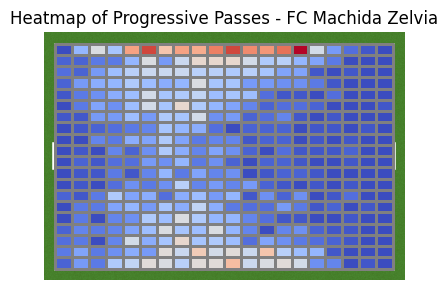

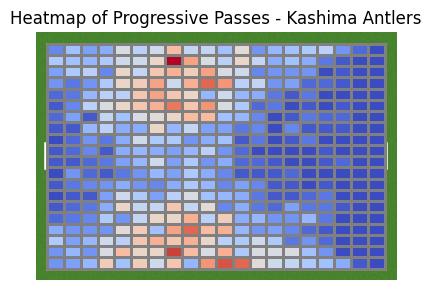

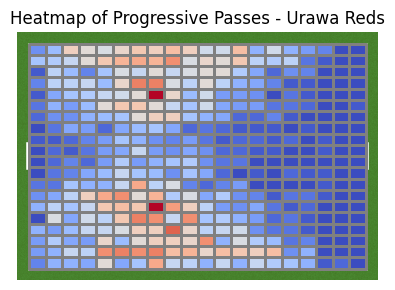

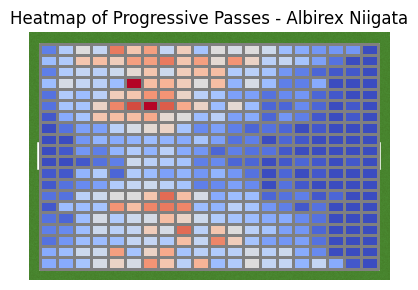

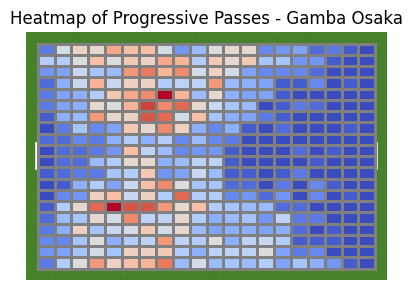

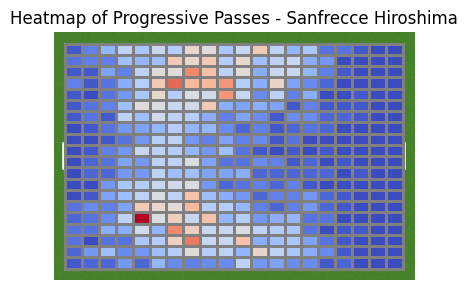

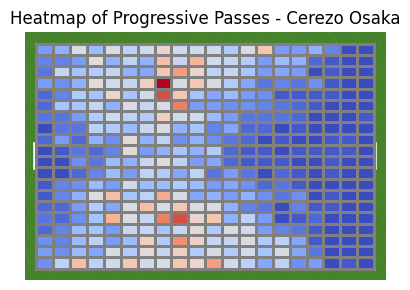

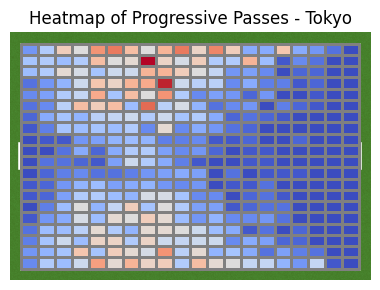

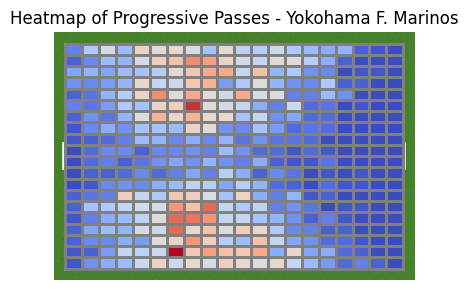

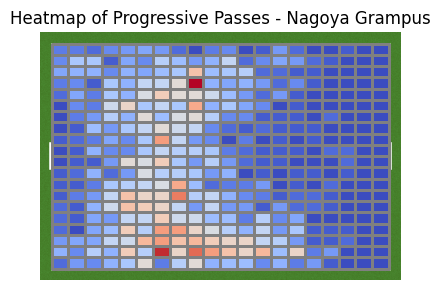

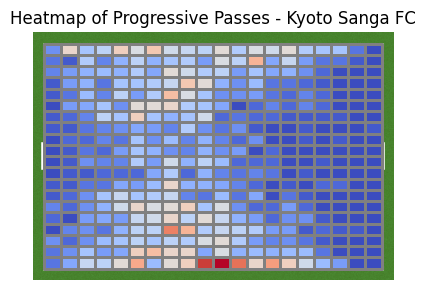

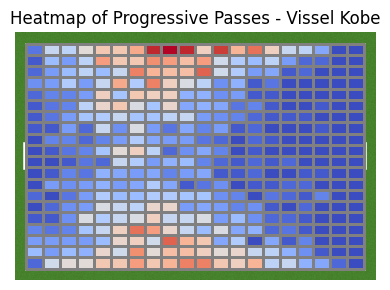

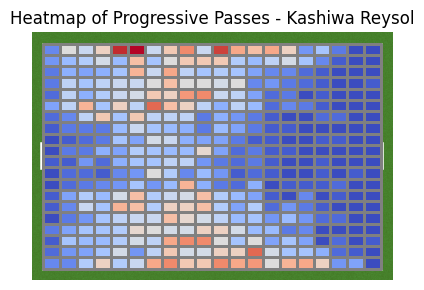

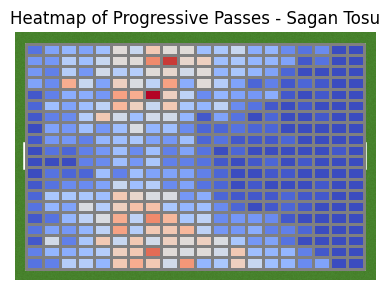

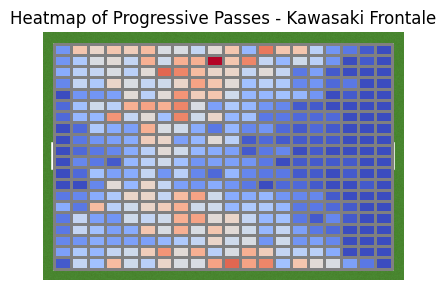

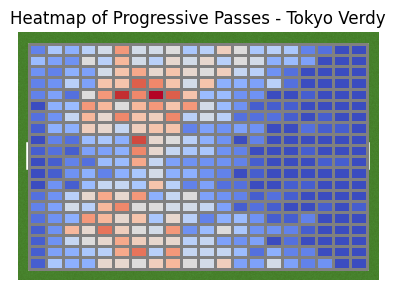

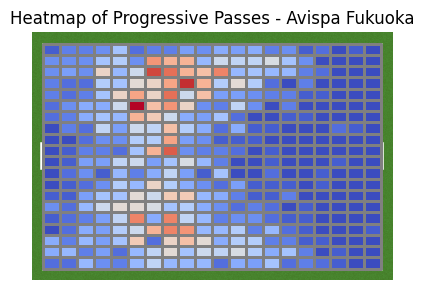

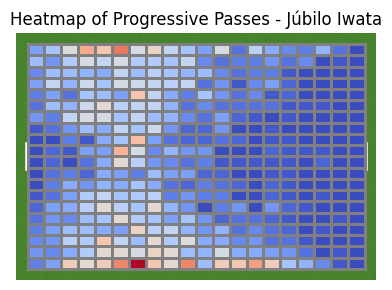

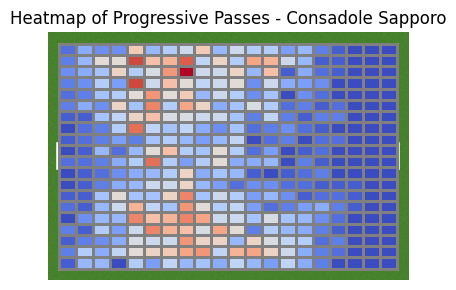

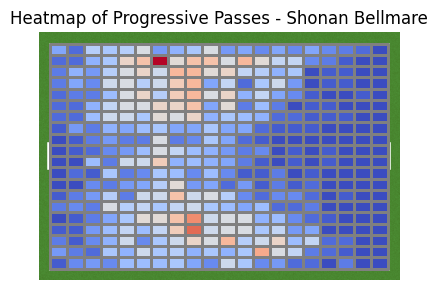

In [42]:
for team in event_data['team'].unique():
  plot_heatmap(event_data,team,'Pass','True',None,['Full Back','Centre Back'])


In [44]:
event_data.columns

Index(['match_id', 'player', 'team', 'team_against', 'position', 'event_type',
       'duel_type', 'start_loc', 'end_loc', 'pressure', 'length',
       'progressive', 'success', 'match_status', 'broad_position'],
      dtype='object')

In [31]:
pitch_x0=0
pitch_x1=120
pitch_y0=0
pitch_y1=80

In [32]:

def calculate_progressive_pass_zones(data, match_status_filter=None):
    # Filter only progressive passes
    prog_passes = data[(data['event_type'] == 'Pass') & (data['progressive'] == 'True')]

    # Extract y-coordinates from start_loc (assuming y-axis runs left to right)
    prog_passes['y_start'] = prog_passes['start_loc'].apply(lambda loc: eval(loc)[1])  # Convert tuple to y

    # Define pitch zones
    prog_passes['zone'] = pd.cut(prog_passes['y_start'],
                                 bins=[0, 26.67, 53.33, 80],
                                 labels=['Left', 'Middle', 'Right'],
                                 include_lowest=True)

    # Count passes per team, per match status, per zone
    zone_counts = prog_passes.groupby(['team', 'zone']).size().unstack(fill_value=0)

    # Calculate percentages
    zone_percentages = zone_counts.div(zone_counts.sum(axis=1), axis=0) * 100

    return zone_percentages.reset_index()

# Example usage
zone_percentage_table = calculate_progressive_pass_zones(event_data)
print(zone_percentage_table)

# Example for only "Losing" match status
losing_zone_percentage_table = calculate_progressive_pass_zones(event_data, match_status_filter=None)
print(losing_zone_percentage_table)


Empty DataFrame
Columns: [team]
Index: []
Empty DataFrame
Columns: [team]
Index: []


<ipython-input-32-db3febec9187>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_counts = prog_passes.groupby(['team', 'zone']).size().unstack(fill_value=0)
<ipython-input-32-db3febec9187>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_counts = prog_passes.groupby(['team', 'zone']).size().unstack(fill_value=0)


In [107]:
# Filter relevant events
filtered_data = event_data[
    ((event_data['event_type'] == 'Block') |
     ((event_data['event_type'] == 'Duel') & (event_data['duel_type'] == 'Tackle'))) &
    (event_data['broad_position'].isin(['Full Back', 'Centre Back']))
]

# Extract x-coordinate from start_loc
filtered_data['x_loc'] = filtered_data['start_loc'].apply(lambda loc: eval(loc)[0])

# Group by team and calculate the mean x-location for blocks
team_x_loc = (
    filtered_data[filtered_data['event_type'] == 'Block']
    .groupby('team')['x_loc']
    .mean()
    .reset_index()
    .rename(columns={'x_loc': 'avg_x_block'})
)

# Merge with tackles data
team_x_tackle = (
    filtered_data[filtered_data['event_type'] == 'Duel']
    .groupby('team')['x_loc']
    .mean()
    .reset_index()
    .rename(columns={'x_loc': 'avg_x_tackle'})
)

# Combine both
team_stats = pd.merge(team_x_loc, team_x_tackle, on='team', how='left')

# Sort by highest average block location
team_stats = team_stats.sort_values(by='avg_x_tackle', ascending=False)

# Display the table
print(team_stats)


                   team  avg_x_block  avg_x_tackle
4     FC Machida Zelvia    30.555333     40.063478
13  Sanfrecce Hiroshima    27.290244     39.116080
19  Yokohama F. Marinos    25.395526     38.913983
0       Albirex Niigata    27.458092     38.880702
10       Kyoto Sanga FC    27.985946     38.736607
2          Cerezo Osaka    28.978593     38.549102
8        Kashiwa Reysol    30.700643     35.931944
16          Tokyo Verdy    26.309211     35.714146
18          Vissel Kobe    29.580000     35.344534
14      Shonan Bellmare    29.188123     35.139912
5           Gamba Osaka    23.840615     34.802632
7       Kashima Antlers    27.106714     34.703535
3     Consadole Sapporo    27.761321     34.438053
17           Urawa Reds    27.387143     34.371837
12           Sagan Tosu    22.476667     33.917801
6          Júbilo Iwata    26.306234     33.509653
9     Kawasaki Frontale    32.359043     33.337770
15                Tokyo    27.196078     32.243049
11       Nagoya Grampus    27.3

<ipython-input-107-a40a55a385d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['x_loc'] = filtered_data['start_loc'].apply(lambda loc: eval(loc)[0])


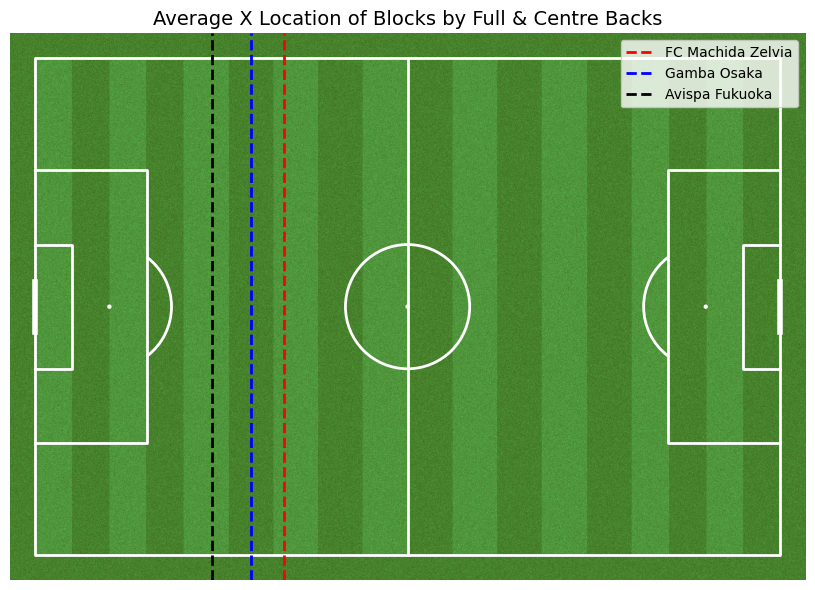

In [108]:
# Get teams for visualization (highest, middle, lowest)
highest_block_team = team_stats.iloc[0]  # Top team
middle_block_team = team_stats.iloc[len(team_stats) // 2]  # Middle team
lowest_block_team = team_stats.iloc[-1]  # Bottom team

# Create pitch
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw(figsize=(10, 6))

# Add vertical lines for each team's average block location
for team_data, color in zip([highest_block_team, middle_block_team, lowest_block_team],
                            ['red', 'blue', 'black']):
    ax.axvline(x=team_data['avg_x_tackle'], color=color, linestyle='--', lw=2, label=team_data['team'])
    #ax.text(team_data['avg_x_block'] + 1, 40, team_data['team'], color=color, fontsize=12, fontweight='bold')

# Add legend
ax.legend()
plt.title("Average X Location of Blocks by Full & Centre Backs", fontsize=14)
plt.show()

In [ ]:
#Ranking of teams with most successful progressive passes
#Teams which favour left/right hand side
#Percentage of passes by defensive line which are long, medium and short
#Areas of pitch where unsuccessful
#Need to have a point for this like if you were looking to recruit a player into the team what would you look for i.e. a right footed left back bla bla who can fill in the gap
